In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
# normalizing flows

#start with a base distribution 1d
base_dist = torch.distributions.normal.Normal(0,1)

#target distribution
target = torch.distributions.Normal(2.0, 0.5)

In [4]:
# start with the transformation for a simple case assume T(x) = a + bx

class Transformation(nn.Module):
  def __init__(self):
    super().__init__()
    self.a = nn.Parameter(torch.randn(1))
    self.b = nn.Parameter(torch.randn(1))

  def forward(self, x):
    #return the value and log det of jacobian
    return self.a + self.b * x, torch.log(torch.abs(self.b))

  def inverse(self, x):
        z = (x - self.a) / self.b
        log_det = -torch.log(torch.abs(self.b))
        return z, log_det


class MultiTransformation(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.flows = nn.ModuleList([Transformation() for _ in range(n)])

    def forward(self, x):
        log_det = torch.zeros_like(x)
        for flow in self.flows:
            x, ld = flow(x)
            log_det += ld
        return x, log_det

    def inverse(self, x):
        log_det = torch.zeros_like(x)
        for flow in reversed(self.flows):
            x, ld = flow.inverse(x)
            log_det += ld
        return x, log_det


class NormalizingFlows(nn.Module):
    def __init__(self, num_flows):
        super().__init__()
        self.flow_chain = MultiTransformation(num_flows)
        self.base_dist = torch.distributions.Normal(0., 1.)

    def log_prob(self, x):
        # Compute inverse pass to get z and total log-det
        z, log_det = self.flow_chain.inverse(x)
        log_pz = self.base_dist.log_prob(z)
        # Return mean log-likelihood over the batch
        return (log_pz + log_det).mean()

    def sample(self, num_samples):
        # Sample from base distribution and push through flows
        z0 = self.base_dist.sample((num_samples,))
        x, _ = self.flow_chain(z0)
        return x


In [5]:
target_dist = torch.distributions.Normal(2.0, 0.5)

model = NormalizingFlows(3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
x_data = target_dist.sample((10000,))
for epoch in range(7000):
    optimizer.zero_grad()
    loss = -model.log_prob(x_data)
    loss.backward()
    optimizer.step()

    if not ((epoch+1)%500):
        print(f"Epoch {epoch+1}, Loss: {loss.item():.7f}")



Epoch 500, Loss: 27.8331623
Epoch 1000, Loss: 10.1506395
Epoch 1500, Loss: 4.8366642
Epoch 2000, Loss: 2.5927913
Epoch 2500, Loss: 1.5368049
Epoch 3000, Loss: 1.0415367
Epoch 3500, Loss: 0.8293660
Epoch 4000, Loss: 0.7532098
Epoch 4500, Loss: 0.7321762
Epoch 5000, Loss: 0.7277604
Epoch 5500, Loss: 0.7266172
Epoch 6000, Loss: 0.7258814
Epoch 6500, Loss: 0.7252690
Epoch 7000, Loss: 0.7248085


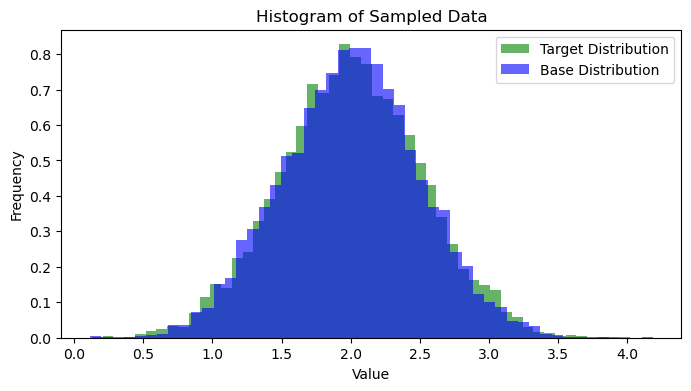

In [6]:

import numpy as np
import torch

# Sample data from the target distribution
target_dist = model
sampled_target_data = target_dist.sample(10000).detach().numpy()

base_dist = torch.distributions.normal.Normal(2,0.5)
sampled_base_data = base_dist.sample((10000,)).numpy()


# Plot a histogram
plt.figure(figsize=(8, 4))
plt.hist(sampled_target_data, bins=50, density=True, alpha=0.6, color='g', label='Target Distribution')
plt.hist(sampled_base_data, bins=50, density=True, alpha=0.6, color='b', label='Base Distribution')
plt.title('Histogram of Sampled Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.show()

# RealNVP

In [8]:
class CouplingLayer(nn.Module):
    def __init__(self, mask, input_dim, hidden_dim, num_hidden):
        super().__init__()
        self.register_buffer('mask', mask)
        self.input_indices = (mask == 1).nonzero(as_tuple=True)[0]
        self.output_indices = (mask == 0).nonzero(as_tuple=True)[0]
        self.in_features = len(self.input_indices)
        self.out_features = len(self.output_indices)

        def build_net():
            layers = [nn.Linear(self.in_features, hidden_dim), nn.ReLU()]
            for _ in range(num_hidden):
                layers += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]
            layers.append(nn.Linear(hidden_dim, self.out_features))
            return nn.Sequential(*layers)

        self.s_net = build_net()
        self.t_net = build_net()

    def forward(self, x):
        x1 = x[:, self.input_indices]
        x2 = x[:, self.output_indices]

        s = self.s_net(x1)
        t = self.t_net(x1)

        y2 = x2 * torch.exp(s) + t
        y = x.clone()
        y[:, self.output_indices] = y2

        log_det = torch.sum(s, dim=1)
        return y, log_det

    def inverse(self, y):
        y1 = y[:, self.input_indices]
        y2 = y[:, self.output_indices]

        s = self.s_net(y1)
        t = self.t_net(y1)

        x2 = (y2 - t) * torch.exp(-s)
        x = y.clone()
        x[:, self.output_indices] = x2

        log_det = -torch.sum(s, dim=1)
        return x, log_det


In [9]:
class RealNVP(nn.Module):
    def __init__(self, num_coupling_layers, input_dim, hidden_dim, num_hidden):
        super().__init__()
        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        for i in range(num_coupling_layers):
            mask = self._create_mask(i)
            self.layers.append(CouplingLayer(mask, input_dim, hidden_dim, num_hidden))

    def _create_mask(self, i):
        mask = torch.zeros(self.input_dim)
        mask[i%2::2] = 1
        return mask

    def forward(self, x):
        log_det = torch.zeros(x.shape[0])
        for layer in self.layers:
            x, ld = layer(x)
            log_det += ld
        return x, log_det

    def inverse(self, z):
        log_det = torch.zeros(z.shape[0])
        for layer in reversed(self.layers):
            z, ld = layer.inverse(z)
            log_det += ld
        return z, log_det

    def log_prob(self, x):
        z, log_det = self.forward(x)
        log_pz = -0.5 * torch.sum(z**2, dim=1) - 0.5 * x.shape[1] * torch.log(torch.tensor(2 * torch.pi))
        return log_pz + log_det

In [10]:
# init the dataset using make_moons
from sklearn.datasets import make_moons, make_s_curve
X, _ = make_s_curve(n_samples=10_000, noise=0.1, random_state=42)

In [11]:
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker
def plot_3d(points, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


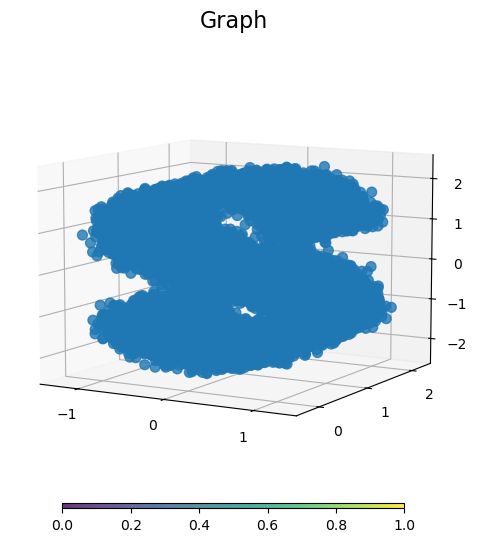

In [12]:
plot_3d(X, "Graph")

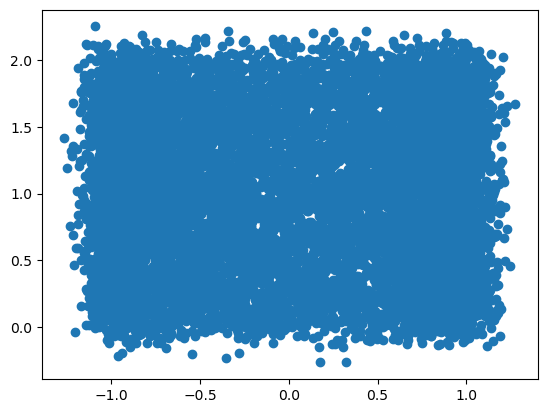

In [13]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1])

In [14]:
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

X = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [15]:
# training loop

model = RealNVP(6, 3, 128, 2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 30

for epoch in range(n_epochs):
    total_loss = 0
    for batch in dataloader:
        x_batch = batch[0]
        optimizer.zero_grad()
        log_likelihood = model.log_prob(x_batch)
        loss = -log_likelihood.mean()  # maximize likelihood = minimize negative log-likelihood
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)

    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/30, Loss: 3.5524
Epoch 2/30, Loss: 3.0764
Epoch 3/30, Loss: 2.8644
Epoch 4/30, Loss: 2.7079
Epoch 5/30, Loss: 2.6277
Epoch 6/30, Loss: 2.5844
Epoch 7/30, Loss: 2.5624
Epoch 8/30, Loss: 2.5238
Epoch 9/30, Loss: 2.4853
Epoch 10/30, Loss: 2.4849
Epoch 11/30, Loss: 2.4420
Epoch 12/30, Loss: 2.4528
Epoch 13/30, Loss: 2.4329
Epoch 14/30, Loss: 2.4044
Epoch 15/30, Loss: 2.4013
Epoch 16/30, Loss: 2.4055
Epoch 17/30, Loss: 2.4129
Epoch 18/30, Loss: 2.3929
Epoch 19/30, Loss: 2.4068
Epoch 20/30, Loss: 2.3626
Epoch 21/30, Loss: 2.3730
Epoch 22/30, Loss: 2.3530
Epoch 23/30, Loss: 2.3538
Epoch 24/30, Loss: 2.3724
Epoch 25/30, Loss: 2.3653
Epoch 26/30, Loss: 2.3313
Epoch 27/30, Loss: 2.3660
Epoch 28/30, Loss: 2.3548
Epoch 29/30, Loss: 2.3365
Epoch 30/30, Loss: 2.3699


In [16]:
# sample from the model
def sample(model, num_samples):
    with torch.no_grad():
        z = torch.randn(num_samples, 3)
        x, _ = model.inverse(z)
    return x.numpy()


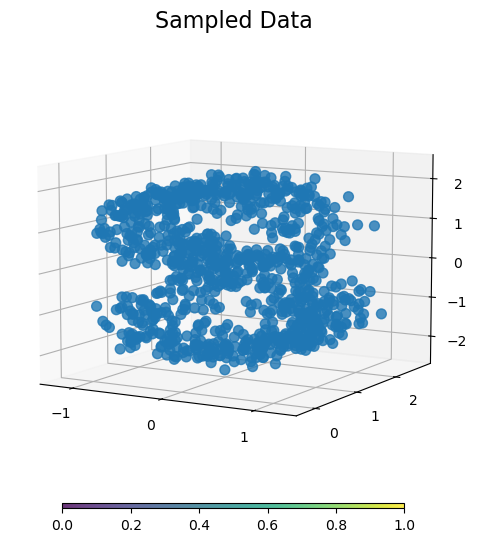

In [17]:
sampled_data = sample(model, 1000)

plot_3d(sampled_data, "Sampled Data")

In [18]:
# Sahith Edula
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

# Data Generation
n_samples = 5000
n_features = 50 # Number of dimensions
n_classes = 4 
n_clusters_per_class = 3 # Number of sub-classes per class

X_np, y_np = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=15,
    n_redundant=5,
    n_classes=n_classes,
    n_clusters_per_class=n_clusters_per_class,
    flip_y=0.02,
    random_state=42
)

# Convert to PyTorch tensors and create DataLoader
X = torch.tensor(X_np, dtype=torch.float32)
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print(f"Generated a dataset with shape: {X.shape}")

Generated a dataset with shape: torch.Size([5000, 50])


In [42]:
X[1:5],
len(X[1])

(tensor([[ 1.8334e-01, -1.9800e+00,  5.5770e-01,  1.1095e+00,  2.0960e+00,
          -1.7980e+00,  3.4248e+00,  1.3034e+00, -1.0692e+00, -2.1061e+00,
           6.6710e+00, -1.1243e+00, -3.1354e+00, -3.5289e-01, -5.7940e-01,
           3.1203e+00,  1.3400e-01,  8.0009e-01, -1.6383e+00,  1.9201e+00,
          -4.1604e-01,  1.2307e+00, -2.3633e+00, -1.1471e+00, -2.6111e-02,
          -1.8816e+00, -5.5356e-01,  1.0484e+00, -1.1964e+00,  8.0093e-01,
          -2.3594e-01, -1.9096e+00,  8.2832e-01,  1.8545e+00,  4.5950e-01,
           2.1988e+00,  4.1342e+00,  2.4075e+00, -5.5338e-01, -5.1987e-01,
           3.7488e+00,  9.6660e-01, -5.1602e+00, -1.0429e+00, -1.1760e+01,
           9.9416e-01,  3.9241e-01,  5.3240e-01,  6.1714e-01, -8.4343e-01],
         [ 7.8586e-01, -6.1548e-01,  7.0510e+00,  2.4261e-01, -7.5083e-01,
           1.4565e-01, -2.3074e+00,  4.7203e-01,  5.6781e-01, -4.3711e+00,
           4.8905e+00, -6.7664e-01, -2.2227e+00,  1.7989e+00,  2.0557e+00,
          -2.9465e+00,  


Starting model training...
Epoch 10/500, Loss: 81.2904
Epoch 20/500, Loss: 74.1134
Epoch 30/500, Loss: 71.2145
Epoch 40/500, Loss: 69.4914
Epoch 50/500, Loss: 69.7545
Epoch 60/500, Loss: 67.4022
Epoch 70/500, Loss: 66.7671
Epoch 80/500, Loss: 66.1600
Epoch 90/500, Loss: 65.8770
Epoch 100/500, Loss: 64.1928
Epoch 110/500, Loss: 64.1932
Epoch 120/500, Loss: 62.6448
Epoch 130/500, Loss: 61.1349
Epoch 140/500, Loss: 61.2325
Epoch 150/500, Loss: 61.4200
Epoch 160/500, Loss: 60.9932
Epoch 170/500, Loss: 59.9361
Epoch 180/500, Loss: 58.3572
Epoch 190/500, Loss: 57.5638
Epoch 200/500, Loss: 172350.2487
Epoch 210/500, Loss: 74.2446
Epoch 220/500, Loss: 68.2822
Epoch 230/500, Loss: 63.8315
Epoch 240/500, Loss: 61.1764
Epoch 250/500, Loss: 59.4110
Epoch 260/500, Loss: 57.9000
Epoch 270/500, Loss: 56.8577
Epoch 280/500, Loss: 56.2688
Epoch 290/500, Loss: 55.3909
Epoch 300/500, Loss: 54.5590
Epoch 310/500, Loss: 53.5511
Epoch 320/500, Loss: 53.4266
Epoch 330/500, Loss: 52.8678
Epoch 340/500, Loss:

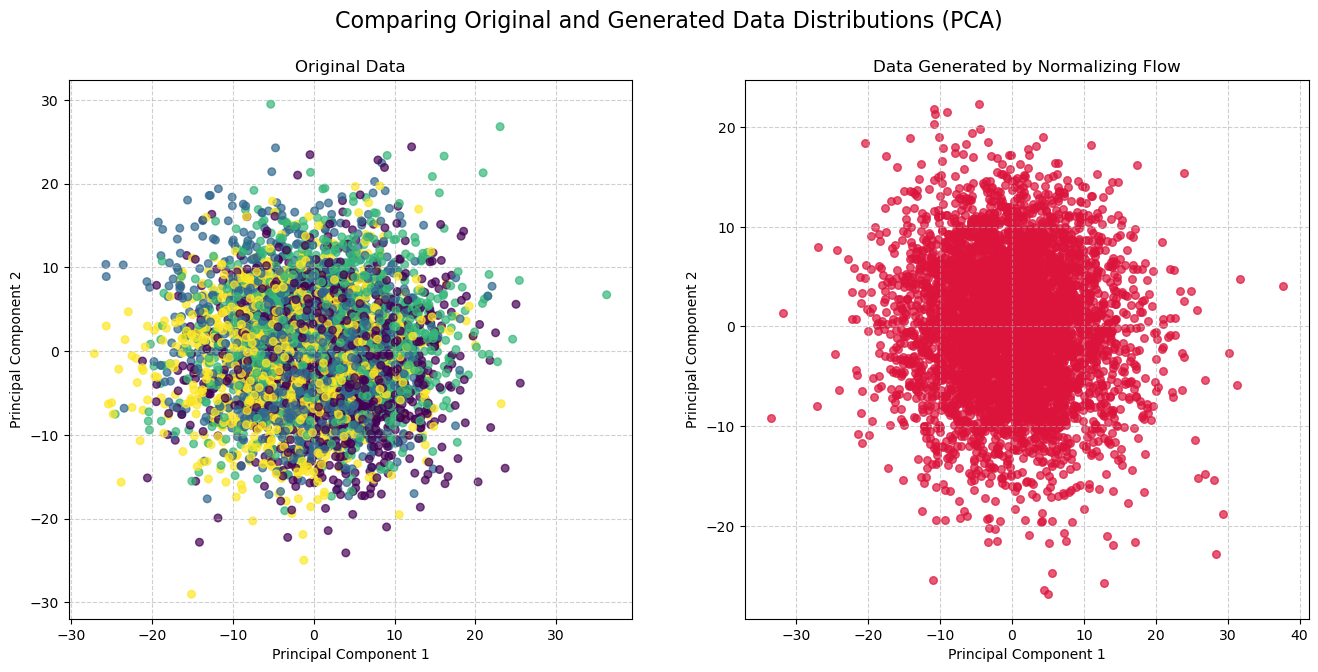

Generated dataset shape: torch.Size([5000, 50])


In [19]:
# Sahith Edula
# Model Training
model = RealNVP(num_coupling_layers=8, input_dim=n_features, hidden_dim=256, num_hidden=2)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
n_epochs = 500

print("\nStarting model training...")
for epoch in range(n_epochs):
    total_loss = 0
    for batch in dataloader:
        x_batch = batch[0]
        optimizer.zero_grad()
        log_likelihood = model.log_prob(x_batch)
        loss = -log_likelihood.mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)

    avg_loss = total_loss / len(dataloader.dataset)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
print("Training finished.")


# Sampling from the Trained Model
def sample(model, num_samples):
    with torch.no_grad():
        # Sample from the base distribution (standard normal)
        z = torch.randn(num_samples, model.input_dim)
        # Apply the inverse transformation to get samples in the original data space
        x_generated, _ = model.inverse(z)
    return x_generated.numpy()

print("\nGenerating new samples from the model...")
generated_samples = sample(model, n_samples)
print(f"Generated samples shape: {generated_samples.shape}")


# Visualization
# Use the same PCA model to transform both original and generated data
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_np)
generated_2d = pca.transform(generated_samples)

# Create plots for comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Comparing Original and Generated Data Distributions (PCA)', fontsize=16)

# Original Data
axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=y_np, cmap='viridis', alpha=0.7, s=30)
axes[0].set_title('Original Data')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Generated Data
axes[1].scatter(generated_2d[:, 0], generated_2d[:, 1], c='crimson', alpha=0.7, s=30)
axes[1].set_title('Data Generated by Normalizing Flow')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.show()
print(f"Generated dataset shape: {X.shape}")